In [1]:
!pip install yfinance
!pip install torchsummaryX
!pip install wandb -q

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 278 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 11.0 MB/s 
     |████████████████████████████████| 182 kB 75.8 MB/s 
     |████████████████████████████████| 168 kB 69.7 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
     |████████████████████████████████| 140 kB 82.7 MB/s 


In [2]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import time
import os
import yfinance as yf
import pandas as pd
import datetime
import torch
import torch.nn as nn
from torchsummaryX import summary
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import gc

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.getcwd()

Mounted at /content/drive


'/content'

In [4]:
import wandb
wandb.login(key="03916b709446813b51f72a1b29a2854a9dd9e3f7")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
# Training Config
config = {
    "batch_size" : 32,
    "lr" : 1e-3,
    "epochs" : 100,
    "look_back" : 60,
    "feature_dim" : 1,
    "hidden_dim" : 64,
    "output_dim" : 1,
    "num_layers" : 3,
    "dropout" : 0.2
}

In [6]:
# load all that we need
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 150)

class VolatiltiyData:

    def __init__(self, tickers, start_year, start_month, start_date, end_year,
                 end_month, end_date, freq, scaling_factor, windows, y_window):
        self.tickers = tickers
        self.start = datetime.datetime(start_year, start_month, start_date)
        self.end = datetime.datetime(end_year, end_month, end_date)
        self.freq = freq
        self.scaling_factor = scaling_factor
        # 过去几天的vol
        self.windows = windows
        # Predict几天的vol
        self.y_window = y_window 

    def get_data(self):
        """
        Output:
        raw data -> ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Log Adj Close', 'Log Return', 10-day-vol']
        """
        data = yf.download(self.tickers, start = self.start, end = self.end, interval = self.freq)
        data["Log Adj Close"] = np.log(data["Adj Close"])
        data["Log Return"] = np.insert(np.diff(data["Log Adj Close"]), 0, 0) * 100
        data["10-day-vol"] = data["Log Return"].rolling(10).std(ddof=0)
        return data
    
    def prepare_data(self, data):
        """
        Prepare data for training. Select features that are needed. Perform necessary normalization.
        
        For volatiltiy data, we need to remove initial n days since we need at least n days to calculate volatiltiy.

        Output:
        dataset ->  (samples, features)
        scalar  ->  scalar for our normalization
        """
        vol_10 = data['10-day-vol'].values
        dataset = vol_10.reshape(-1, 1)[11:]
        
        # normalize the dataset
        scaler = MinMaxScaler(feature_range=(0, 1))
        dataset = scaler.fit_transform(dataset)
        return dataset, scaler

volatiltiy_data = VolatiltiyData(
                      "^GSPC",
                      1990, 1, 2,
                      2022, 12, 12,
                      freq="1d",
                      scaling_factor=100,
                      windows=[10], # 过去几天的vol
                      y_window=10 # Predict几天的vol
                  )

data = volatiltiy_data.get_data()
dataset, scaler = volatiltiy_data.prepare_data(data)
print(np.shape(dataset))

[*********************100%***********************]  1 of 1 completed
(8290, 1)


In [7]:
class DataLoaderForVolatilityModeling(DataLoader):
    """
    Construct dataloader
  
    The label for our data is the next 10-day volatility after our input.

    Output:
    input -> (batch_size, seq_len, feature_size)
    label -> (batch_size, 1, feature_size) 
    """
    def __init__(self, dataset, batch_size, sequence_length, shuffle=True, feature_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.sequence_length = sequence_length
        self.num_batches = (np.shape(self.dataset)[0]-10) // self.batch_size
        self.feature_size = feature_size

    def __len__(self):
        return self.num_batches - self.sequence_length

    def __iter__(self):
        # group the sequence into batches
        x = torch.from_numpy(np.reshape(self.dataset[:self.num_batches*self.batch_size, :], (self.batch_size, -1))).type(torch.float32)
        y = torch.from_numpy(np.reshape(self.dataset[10:self.num_batches*self.batch_size+10, :], (self.batch_size, -1))).type(torch.float32)

        # return a tuple of (input, label) on every iteration with yield
        index = 0
        while index+self.sequence_length < self.num_batches:
            time_steps = self.sequence_length
            input = x[:, index:index+time_steps].view(self.batch_size, time_steps, self.feature_size)
            label = y[:, index+time_steps].view(self.batch_size, self.feature_size)
            index += 1
            yield input, label

In [8]:
# sanity check
dataloader = DataLoaderForVolatilityModeling(dataset, batch_size=config["batch_size"], sequence_length=config["look_back"])
tmp = iter(dataloader)
input, label = next(tmp)
print(f'input shape = {np.shape(input)}')
print(f'label shape = {np.shape(label)}')

input shape = torch.Size([32, 60, 1])
label shape = torch.Size([32, 1])


In [9]:
# model
class Model(nn.Module):
    """
    Construct model architecture
    """
    def __init__(self, feature_dim, hidden_dim, output_dim):
        super(Model, self).__init__()
        self.cnns = torch.nn.Sequential(
            torch.nn.Conv1d(feature_dim, hidden_dim, kernel_size=3, padding=1, bias=False),
            torch.nn.BatchNorm1d(hidden_dim),
            torch.nn.ReLU(inplace=True)
        )
        self.lstm = torch.nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=config["num_layers"], 
                                  dropout=config["dropout"], batch_first=True, bias=True)
        self.relu = torch.nn.ReLU()
        self.linear = torch.nn.Linear(in_features=hidden_dim, out_features=output_dim, bias=True)

    def forward(self, x):
        # x : (batch_size, time_steps, feature_size)
        x = x.permute(0, 2, 1) # x : (batch_size, feature_sizem, time_steps)
        cnn_out = self.cnns(x) # cnn_out : (batch_size, feature_sizem, time_steps)
        rnn_in = cnn_out.permute(0, 2, 1) # rnn_in : (batch_size, time_steps, feature_size)
        x, h = self.lstm(rnn_in)
        x = x[:, -1, :]
        x = self.relu(x)
        x = self.linear(x)
        return x

In [10]:
# sanity check
torch.cuda.empty_cache()

model = Model(config['feature_dim'], config['hidden_dim'], config['output_dim']).to(device)
prediction = model(input.to(device))
print(f'shape of prediction : {prediction.shape}')
print(f'shape of label : {label.shape}')

summary(model, input.to(device))

shape of prediction : torch.Size([32, 1])
shape of label : torch.Size([32, 1])
                     Kernel Shape  Output Shape  Params Mult-Adds
Layer                                                            
0_cnns.Conv1d_0        [1, 64, 3]  [32, 64, 60]   192.0    11.52k
1_cnns.BatchNorm1d_1         [64]  [32, 64, 60]   128.0      64.0
2_cnns.ReLU_2                   -  [32, 64, 60]       -         -
3_lstm                          -  [32, 60, 64]  99.84k   98.304k
4_relu                          -      [32, 64]       -         -
5_linear                  [64, 1]       [32, 1]    65.0      64.0
-------------------------------------------------------------------
                        Totals
Total params          100.225k
Trainable params      100.225k
Non-trainable params       0.0
Mult-Adds             109.952k


/usr/local/lib/python3.8/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_cnns.Conv1d_0,"[1, 64, 3]","[32, 64, 60]",192.0,11520.0
1_cnns.BatchNorm1d_1,[64],"[32, 64, 60]",128.0,64.0
2_cnns.ReLU_2,-,"[32, 64, 60]",NaN,NaN
3_lstm,-,"[32, 60, 64]",99840.0,98304.0
4_relu,-,"[32, 64]",NaN,NaN
5_linear,"[64, 1]","[32, 1]",65.0,64.0


In [11]:
# Prepare loader
train_size = int(len(dataset) * 0.5)
val_size = int(len(dataset) * 0.2)
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = dataset[0:train_size,:], dataset[train_size:train_size+val_size,:], dataset[train_size+val_size:len(dataset),:]

train_loader = DataLoaderForVolatilityModeling(train_data, batch_size=config['batch_size'], sequence_length=config['look_back'], shuffle=True)
val_loader = DataLoaderForVolatilityModeling(val_data, batch_size=10, sequence_length=config['look_back'], shuffle=False)
test_loader = DataLoaderForVolatilityModeling(test_data, batch_size=1, sequence_length=config['look_back'], shuffle=False)

# Prepare optimizer, criterion, and scheduler_lr
optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay = 5e-5) # What goes in here?
criterion = torch.nn.MSELoss()
scheduler_lr = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.75, patience=2, verbose=True)

In [12]:
# Evaluate
def evaluate(val_loader, model, criterion):
    model.eval()

    batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc="Val")

    val_loss = 0

    for i, (input, target) in enumerate(val_loader):

        input, target = input.to(device), target.to(device)

        with torch.inference_mode():
            prediction = model(input)

        loss = criterion(prediction.flatten(), target.flatten())

        val_loss += loss.item()
        # print(loss.item())

        batch_bar.set_postfix(
            loss = f"{val_loss/ (i+1):.4f}",
            lr = f"{curr_lr}"
        )

        batch_bar.update()

        torch.cuda.empty_cache()
        del input
        del target

    batch_bar.close()
    val_loss /= len(dataloader)

    return val_loss

In [13]:
# Train Step
def train_step(train_loader, model, optimizer, criterion):
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
    train_loss = 0
    model.train()

    for i, (input, target) in enumerate(train_loader):
        input, target = input.to(device), target.to(device)
        curr_lr = optimizer.param_groups[0]['lr']

        optimizer.zero_grad()
        prediction = model(input)
        # print(f'prediction : {prediction}')
        # print(f'target : {target}')
        loss = criterion(prediction.flatten(), target.flatten())
        # print(f'loss : {loss.item()}')

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        batch_bar.set_postfix(
            loss = f"{train_loss/ (i+1):.4f}",
            lr = f"{curr_lr}"
        )

        batch_bar.update()

        torch.cuda.empty_cache()
        del input
        del target
    
    batch_bar.close()
    train_loss /= len(train_loader)
    
    return train_loss

In [14]:
# Initialize wandb
run = wandb.init(
    name = "LSTM_sing_feats_CNN", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "10701_Volatility_Prediction", ### Project should be created in your wandb account 
    config = config ### Wandb Config for your run
)

wandb: Currently logged in as: quantoalpha. Use `wandb login --relogin` to force relogin


In [15]:
best_val_loss = 100

# Train loop
torch.cuda.empty_cache()
gc.collect()

train_loss, val_loss = 0, 0

for epoch in range(config["epochs"]):
    
    curr_lr = optimizer.param_groups[0]['lr']

    train_loss = train_step(train_loader, model, optimizer, criterion)

    val_loss = evaluate(val_loader, model, criterion)

    scheduler_lr.step(train_loss)

    print("\nEpoch {}/{}: \n\t Train Loss {:.07f}\t Eval Loss {:.07f}\t Learning Rate {:.04f}\t".format(
          epoch + 1,
          config['epochs'],
          train_loss,
          val_loss,
          curr_lr))
    
    wandb.log({"train_loss":train_loss, 'val_loss': val_loss, "learning_Rate": curr_lr})
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        path = '/content/drive/MyDrive/10701/checkpoint/checkpoint_eval_loss_bidrectional'
        torch.save({'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler': scheduler_lr.state_dict(),
                    'val_loss': val_loss, 
                    'epoch': epoch}, path)
wandb.save(path)
run.finish()


Epoch 1/100: 
	 Train Loss 0.0038647	 Eval Loss 0.0083669	 Learning Rate 0.0010	



Epoch 2/100: 
	 Train Loss 0.0023239	 Eval Loss 0.0081717	 Learning Rate 0.0010	



Epoch 3/100: 
	 Train Loss 0.0022568	 Eval Loss 0.0082003	 Learning Rate 0.0010	



Epoch 4/100: 
	 Train Loss 0.0022506	 Eval Loss 0.0081016	 Learning Rate 0.0010	



Epoch 5/100: 
	 Train Loss 0.0022812	 Eval Loss 0.0083526	 Learning Rate 0.0010	



Epoch 6/100: 
	 Train Loss 0.0022069	 Eval Loss 0.0086015	 Learning Rate 0.0010	



Epoch 7/100: 
	 Train Loss 0.0021338	 Eval Loss 0.0087502	 Learning Rate 0.0010	



Epoch 8/100: 
	 Train Loss 0.0020663	 Eval Loss 0.0086617	 Learning Rate 0.0010	



Epoch 9/100: 
	 Train Loss 0.0020328	 Eval Loss 0.0083152	 Learning Rate 0.0010	



Epoch 10/100: 
	 Train Loss 0.0019942	 Eval Loss 0.0084288	 Learning Rate 0.0010	



Epoch 11/100: 
	 Train Loss 0.0019851	 Eval Loss 0.0088363	 Learning Rate 0.0010	



Epoch 12/100: 
	 Train Loss 0.0021540	 Eval Loss 0.0076610	 Learning Rate 0.0010	



Epoch 13/100: 
	 Train Loss 0.0020865	 Eval Loss 0.0085157	 Learning Rate 0.0010	


Epoch 00014: reducing learning rate of group 0 to 7.5000e-04.

Epoch 14/100: 
	 Train Loss 0.0020680	 Eval Loss 0.0084991	 Learning Rate 0.0010	



Epoch 15/100: 
	 Train Loss 0.0020214	 Eval Loss 0.0082194	 Learning Rate 0.0008	



Epoch 16/100: 
	 Train Loss 0.0019494	 Eval Loss 0.0080200	 Learning Rate 0.0008	



Epoch 17/100: 
	 Train Loss 0.0019270	 Eval Loss 0.0081020	 Learning Rate 0.0008	



Epoch 18/100: 
	 Train Loss 0.0019424	 Eval Loss 0.0082562	 Learning Rate 0.0008	



Epoch 19/100: 
	 Train Loss 0.0019084	 Eval Loss 0.0083041	 Learning Rate 0.0008	



Epoch 20/100: 
	 Train Loss 0.0019111	 Eval Loss 0.0082217	 Learning Rate 0.0008	



Epoch 21/100: 
	 Train Loss 0.0019006	 Eval Loss 0.0085539	 Learning Rate 0.0008	



Epoch 22/100: 
	 Train Loss 0.0018698	 Eval Loss 0.0085743	 Learning Rate 0.0008	



Epoch 23/100: 
	 Train Loss 0.0017463	 Eval Loss 0.0083062	 Learning Rate 0.0008	



Epoch 24/100: 
	 Train Loss 0.0018540	 Eval Loss 0.0076896	 Learning Rate 0.0008	



Epoch 25/100: 
	 Train Loss 0.0017826	 Eval Loss 0.0088753	 Learning Rate 0.0008	



Epoch 26/100: 
	 Train Loss 0.0016721	 Eval Loss 0.0080114	 Learning Rate 0.0008	



Epoch 27/100: 
	 Train Loss 0.0016048	 Eval Loss 0.0100216	 Learning Rate 0.0008	



Epoch 28/100: 
	 Train Loss 0.0016067	 Eval Loss 0.0101168	 Learning Rate 0.0008	



Epoch 29/100: 
	 Train Loss 0.0015253	 Eval Loss 0.0084468	 Learning Rate 0.0008	



Epoch 30/100: 
	 Train Loss 0.0013218	 Eval Loss 0.0092622	 Learning Rate 0.0008	



Epoch 31/100: 
	 Train Loss 0.0014237	 Eval Loss 0.0096864	 Learning Rate 0.0008	



Epoch 32/100: 
	 Train Loss 0.0015304	 Eval Loss 0.0089146	 Learning Rate 0.0008	



Epoch 33/100: 
	 Train Loss 0.0012823	 Eval Loss 0.0103531	 Learning Rate 0.0008	



Epoch 34/100: 
	 Train Loss 0.0013680	 Eval Loss 0.0114947	 Learning Rate 0.0008	



Epoch 35/100: 
	 Train Loss 0.0013302	 Eval Loss 0.0102075	 Learning Rate 0.0008	


Epoch 00036: reducing learning rate of group 0 to 5.6250e-04.

Epoch 36/100: 
	 Train Loss 0.0013049	 Eval Loss 0.0105827	 Learning Rate 0.0008	



Epoch 37/100: 
	 Train Loss 0.0012580	 Eval Loss 0.0095476	 Learning Rate 0.0006	



Epoch 38/100: 
	 Train Loss 0.0013728	 Eval Loss 0.0106035	 Learning Rate 0.0006	



Epoch 39/100: 
	 Train Loss 0.0013005	 Eval Loss 0.0097625	 Learning Rate 0.0006	



Epoch 40/100: 
	 Train Loss 0.0011804	 Eval Loss 0.0093546	 Learning Rate 0.0006	



Epoch 41/100: 
	 Train Loss 0.0010932	 Eval Loss 0.0096694	 Learning Rate 0.0006	



Epoch 42/100: 
	 Train Loss 0.0010280	 Eval Loss 0.0098895	 Learning Rate 0.0006	



Epoch 43/100: 
	 Train Loss 0.0009515	 Eval Loss 0.0105434	 Learning Rate 0.0006	



Epoch 44/100: 
	 Train Loss 0.0009230	 Eval Loss 0.0099375	 Learning Rate 0.0006	



Epoch 45/100: 
	 Train Loss 0.0011073	 Eval Loss 0.0101627	 Learning Rate 0.0006	



Epoch 46/100: 
	 Train Loss 0.0010367	 Eval Loss 0.0098259	 Learning Rate 0.0006	


Epoch 00047: reducing learning rate of group 0 to 4.2188e-04.

Epoch 47/100: 
	 Train Loss 0.0009884	 Eval Loss 0.0105759	 Learning Rate 0.0006	



Epoch 48/100: 
	 Train Loss 0.0009298	 Eval Loss 0.0105368	 Learning Rate 0.0004	



Epoch 49/100: 
	 Train Loss 0.0008950	 Eval Loss 0.0108134	 Learning Rate 0.0004	



Epoch 50/100: 
	 Train Loss 0.0008663	 Eval Loss 0.0100131	 Learning Rate 0.0004	



Epoch 51/100: 
	 Train Loss 0.0008005	 Eval Loss 0.0101149	 Learning Rate 0.0004	



Epoch 52/100: 
	 Train Loss 0.0007832	 Eval Loss 0.0096522	 Learning Rate 0.0004	



Epoch 53/100: 
	 Train Loss 0.0007656	 Eval Loss 0.0097042	 Learning Rate 0.0004	



Epoch 54/100: 
	 Train Loss 0.0007394	 Eval Loss 0.0100322	 Learning Rate 0.0004	



Epoch 55/100: 
	 Train Loss 0.0006737	 Eval Loss 0.0099688	 Learning Rate 0.0004	



Epoch 56/100: 
	 Train Loss 0.0006616	 Eval Loss 0.0098373	 Learning Rate 0.0004	



Epoch 57/100: 
	 Train Loss 0.0006420	 Eval Loss 0.0104595	 Learning Rate 0.0004	



Epoch 58/100: 
	 Train Loss 0.0006092	 Eval Loss 0.0102195	 Learning Rate 0.0004	



Epoch 59/100: 
	 Train Loss 0.0005727	 Eval Loss 0.0102605	 Learning Rate 0.0004	



Epoch 60/100: 
	 Train Loss 0.0005875	 Eval Loss 0.0100799	 Learning Rate 0.0004	



Epoch 61/100: 
	 Train Loss 0.0005677	 Eval Loss 0.0106627	 Learning Rate 0.0004	



Epoch 62/100: 
	 Train Loss 0.0005601	 Eval Loss 0.0104325	 Learning Rate 0.0004	



Epoch 63/100: 
	 Train Loss 0.0005712	 Eval Loss 0.0109241	 Learning Rate 0.0004	



Epoch 64/100: 
	 Train Loss 0.0005553	 Eval Loss 0.0101361	 Learning Rate 0.0004	



Epoch 65/100: 
	 Train Loss 0.0005284	 Eval Loss 0.0098933	 Learning Rate 0.0004	



Epoch 66/100: 
	 Train Loss 0.0005086	 Eval Loss 0.0101498	 Learning Rate 0.0004	



Epoch 67/100: 
	 Train Loss 0.0005315	 Eval Loss 0.0104631	 Learning Rate 0.0004	



Epoch 68/100: 
	 Train Loss 0.0005358	 Eval Loss 0.0103843	 Learning Rate 0.0004	


Epoch 00069: reducing learning rate of group 0 to 3.1641e-04.

Epoch 69/100: 
	 Train Loss 0.0007191	 Eval Loss 0.0104277	 Learning Rate 0.0004	



Epoch 70/100: 
	 Train Loss 0.0006002	 Eval Loss 0.0099554	 Learning Rate 0.0003	



Epoch 71/100: 
	 Train Loss 0.0005225	 Eval Loss 0.0102651	 Learning Rate 0.0003	


Epoch 00072: reducing learning rate of group 0 to 2.3730e-04.

Epoch 72/100: 
	 Train Loss 0.0005179	 Eval Loss 0.0101811	 Learning Rate 0.0003	



Epoch 73/100: 
	 Train Loss 0.0004941	 Eval Loss 0.0101557	 Learning Rate 0.0002	



Epoch 74/100: 
	 Train Loss 0.0004599	 Eval Loss 0.0100146	 Learning Rate 0.0002	



Epoch 75/100: 
	 Train Loss 0.0004464	 Eval Loss 0.0100189	 Learning Rate 0.0002	



Epoch 76/100: 
	 Train Loss 0.0004565	 Eval Loss 0.0099961	 Learning Rate 0.0002	



Epoch 77/100: 
	 Train Loss 0.0004202	 Eval Loss 0.0101428	 Learning Rate 0.0002	



Epoch 78/100: 
	 Train Loss 0.0004177	 Eval Loss 0.0100087	 Learning Rate 0.0002	



Epoch 79/100: 
	 Train Loss 0.0004117	 Eval Loss 0.0100537	 Learning Rate 0.0002	



Epoch 80/100: 
	 Train Loss 0.0003991	 Eval Loss 0.0099849	 Learning Rate 0.0002	



Epoch 81/100: 
	 Train Loss 0.0003925	 Eval Loss 0.0099694	 Learning Rate 0.0002	



Epoch 82/100: 
	 Train Loss 0.0003874	 Eval Loss 0.0098874	 Learning Rate 0.0002	



Epoch 83/100: 
	 Train Loss 0.0003822	 Eval Loss 0.0099082	 Learning Rate 0.0002	



Epoch 84/100: 
	 Train Loss 0.0003761	 Eval Loss 0.0098249	 Learning Rate 0.0002	



Epoch 85/100: 
	 Train Loss 0.0003749	 Eval Loss 0.0099913	 Learning Rate 0.0002	



Epoch 86/100: 
	 Train Loss 0.0003669	 Eval Loss 0.0099748	 Learning Rate 0.0002	



Epoch 87/100: 
	 Train Loss 0.0003691	 Eval Loss 0.0099270	 Learning Rate 0.0002	



Epoch 88/100: 
	 Train Loss 0.0003552	 Eval Loss 0.0099057	 Learning Rate 0.0002	



Epoch 89/100: 
	 Train Loss 0.0003451	 Eval Loss 0.0099811	 Learning Rate 0.0002	



Epoch 90/100: 
	 Train Loss 0.0003443	 Eval Loss 0.0098847	 Learning Rate 0.0002	



Epoch 91/100: 
	 Train Loss 0.0003331	 Eval Loss 0.0098323	 Learning Rate 0.0002	



Epoch 92/100: 
	 Train Loss 0.0003436	 Eval Loss 0.0097929	 Learning Rate 0.0002	



Epoch 93/100: 
	 Train Loss 0.0003377	 Eval Loss 0.0099666	 Learning Rate 0.0002	



Epoch 94/100: 
	 Train Loss 0.0003324	 Eval Loss 0.0098152	 Learning Rate 0.0002	



Epoch 95/100: 
	 Train Loss 0.0003200	 Eval Loss 0.0099235	 Learning Rate 0.0002	



Epoch 96/100: 
	 Train Loss 0.0003171	 Eval Loss 0.0098707	 Learning Rate 0.0002	



Epoch 97/100: 
	 Train Loss 0.0003234	 Eval Loss 0.0099962	 Learning Rate 0.0002	



Epoch 98/100: 
	 Train Loss 0.0003271	 Eval Loss 0.0099538	 Learning Rate 0.0002	


Epoch 00099: reducing learning rate of group 0 to 1.7798e-04.

Epoch 99/100: 
	 Train Loss 0.0003262	 Eval Loss 0.0099718	 Learning Rate 0.0002	


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")



Epoch 100/100: 
	 Train Loss 0.0003104	 Eval Loss 0.0098271	 Learning Rate 0.0002	


learning_Rate,██████▆▆▆▆▆▆▆▆▆▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁
train_loss,█▅▅▄▄▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▁▂▂▃▂▁▁▂▂▁▅▄█▆▅▄▅▅▇▅▅▅▆▆▅▆▆▅▅▅▅▅▅▅▅▅▅▅▅
learning_Rate,0.00018
train_loss,0.00031
val_loss,0.00983


In [16]:
# Prediction
def predict(test_loader, model):
    model.eval()
    preds, targets = [], []
    test_loss = 0

    for i, (input, target) in enumerate(test_loader):

        input, target = input.to(device), target.to(device)

        with torch.inference_mode():
            prediction = model(input)

        test_loss += criterion(prediction.flatten(), target.flatten())

        # Note: Each loaded data is a column
        prediction = prediction.cpu().detach().numpy() # (batch_size, feature_size)
        target = target.cpu().detach().numpy() # (batch_size, feature_size)

        preds.append(prediction.flatten()[0])
        targets.append(target.flatten()[0])

        del input
        del target
    
    test_loss /= len(test_loader)

    return preds, targets, test_loss

In [20]:
torch.cuda.empty_cache()
gc.collect()

preds, targets, test_loss = predict(test_loader, model)

loss = 'Eval loss : {:.07}'.format(best_val_loss)
print(loss)

loss = 'Test loss : {:.07}'.format(test_loss)
print(loss)

Eval loss : 0.007660965
Test loss : 0.009461939


In [30]:
print(preds)
print(targets)

[0.06668945, 0.06463735, 0.065580696, 0.06780628, 0.06819901, 0.071338, 0.07406831, 0.0759832, 0.07489377, 0.06620436, 0.05665528, 0.05273436, 0.04950982, 0.046852086, 0.04525379, 0.044481423, 0.04757583, 0.048934765, 0.04823836, 0.048952714, 0.049856763, 0.053996462, 0.05656202, 0.056665752, 0.050168153, 0.044900745, 0.041072115, 0.04580877, 0.061837852, 0.06051342, 0.060711265, 0.059775777, 0.06360904, 0.0644164, 0.060043734, 0.053709064, 0.051567074, 0.048833605, 0.048997667, 0.04998093, 0.05277144, 0.058304794, 0.061867908, 0.06400967, 0.066729195, 0.0711471, 0.07647686, 0.081231296, 0.083964, 0.087029725, 0.08916123, 0.08731069, 0.08730012, 0.08685163, 0.08535816, 0.08286529, 0.07839282, 0.072665885, 0.06886489, 0.06537945, 0.06294078, 0.059475817, 0.055910025, 0.053018115, 0.050952747, 0.048943024, 0.045384552, 0.04289884, 0.041205674, 0.03971391, 0.04130842, 0.04311066, 0.04304704, 0.04374965, 0.044809707, 0.044711217, 0.045363557, 0.04543359, 0.045360677, 0.045950625, 0.0459328

In [27]:
mse = 0

for i in range(len(preds)):
    mse += (preds[i] - targets[i])**2

print(mse/len(preds))

0.009461936222617283


In [29]:
print(len(targets))

2417


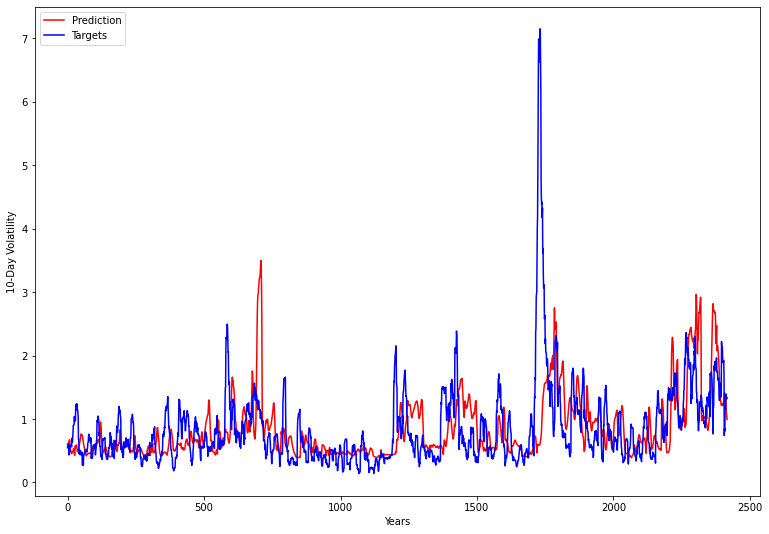

In [35]:
plt.figure(figsize=(13,9))
plt.plot(np.arange(len(preds)), scaler.inverse_transform(np.array(preds).reshape(-1, 1)), label="Prediction", color="red")
plt.plot(np.arange(len(targets)), scaler.inverse_transform(np.array(targets).reshape(-1, 1)), label="Targets", color="blue")
plt.xlabel("Years")
plt.ylabel("10-Day Volatility")
plt.legend(loc="upper left")
plt.show()

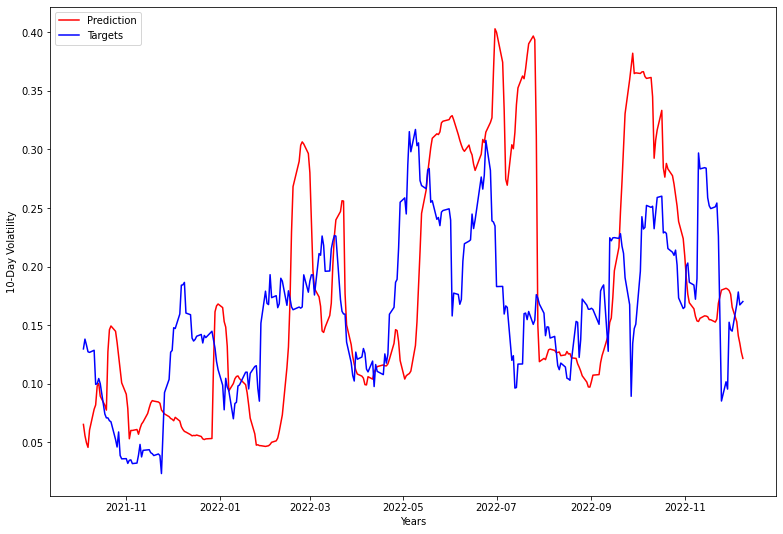

In [32]:
df = data.copy()
df = df.tail(len(preds))
df.drop(df.columns, inplace=True, axis=1)
df['preds'] = preds

# Generate output
plt.figure(figsize=(13,9))
plt.plot(df.index[-300:], preds[-300:], label="Prediction", color="red")
plt.plot(df.index[-300:], targets[-300:], label="Targets", color="blue")
plt.xlabel("Years")
plt.ylabel("10-Day Volatility")
plt.legend(loc="upper left")
plt.show()

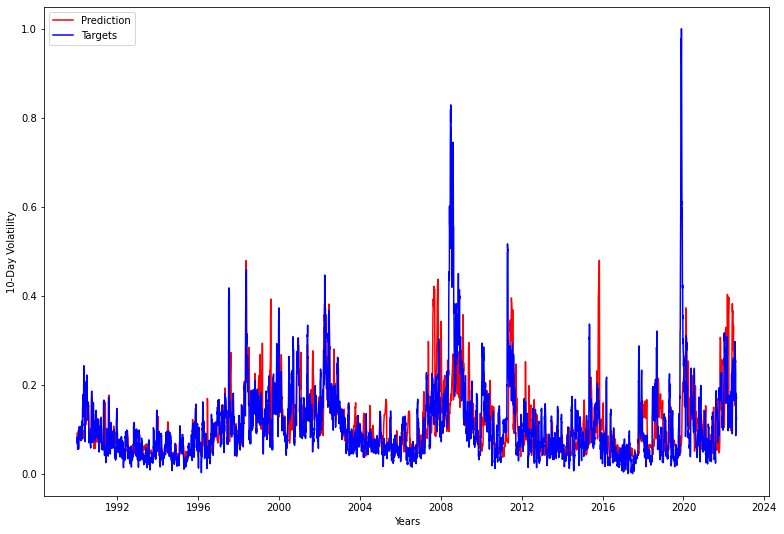

Test loss : 0.006620138


In [19]:
# Prediction for the entire dataset
data_loader = DataLoaderForVolatilityModeling(dataset, batch_size=1, sequence_length=config['look_back'], shuffle=False)

# Make predictions
preds, targets, test_loss = predict(data_loader, model)

# Generate output
plt.figure(figsize=(13,9))
plt.plot(data.index[:len(preds)], preds, label="Prediction", color="red")
plt.plot(data.index[:len(targets)], targets, label="Targets", color="blue")
plt.xlabel("Years")
plt.ylabel("10-Day Volatility")
plt.legend(loc="upper left")
plt.show()

loss = 'Test loss : {:.07}'.format(test_loss)
print(loss)